<a href="https://colab.research.google.com/github/MunibUrRehmanMemon/Mutli-Agentic-Chatbot/blob/main/Multi_Agent_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langgraph langchain langsmith langchain_groq langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 18.0 MB/s eta 0:00:00


In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.6 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=e0ea96092e26254cabcffe9b96909d1c077966842003824c3c5abd30e5e20351
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=fdb66aff36df328997cfcefde00a7e847a8549912b8e1fa3a1cbf84c8940a7be
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built wikipedia sgmllib3k


In [ ]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper= arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper= api_wrapper)



In [ ]:
wiki_tool.invoke("Taliban")

"Page: Taliban\nSummary: The Taliban (; Pashto: طَالِبَانْ, romanized: Tālibān, lit.\u2009'students'), which also refers to itself by its state name, the Islamic Emirate of Afghanistan, is an Afghan political and militant movement with an ideology comprising elements of Pashtun nationalism and the Deobandi"

In [ ]:
arxiv_tool.invoke("RAG")

'Published: 2024-07-26\nTitle: Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks\nAuthors: Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang\nSummary: Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledg'

In [ ]:
tools= [wiki_tool, arxiv_tool]

In [ ]:
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]


In [ ]:
from langgraph.graph import START, StateGraph, END

In [ ]:
graph_builder = StateGraph(State)

In [ ]:
from langchain_groq import ChatGroq

In [ ]:
from google.colab import userdata
groq_api_key = userdata.get("groq_api_key")

llm = ChatGroq(groq_api_key= groq_api_key, model_name= "Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f2c80e79bd0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f2c807f63d0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
llm_with_tools= llm.bind_tools(tools=tools)

In [ ]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [ ]:
from langgraph.prebuilt import ToolNode,tools_condition

In [ ]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [ ]:
graph= graph_builder.compile()

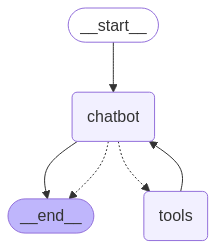

In [ ]:
# from logging import exception
from IPython.display import display, Image

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
user_input= "tell me about research on Agentic AI"

events= graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

tell me about research on Agentic AI
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_9fz1)
 Call ID: call_9fz1
  Args:
    query: Agentic AI
================================= Tool Message =================================
Name: arxiv

Published: 2025-02-25
Title: Responsible AI Agents
Authors: Deven R. Desai, Mark O. Riedl
Summary: Thanks to advances in large language models, a new type of software agent,
the artificial intelligence (AI) agent, has entered the marketplace. Companies
such as OpenAI, Google, Microsoft, and Salesfor
================================== Ai Message ==================================

Agentic AI is a relatively new field of research focusing on developing AI agents that can act autonomously and achieve goals in complex environments. 

Recent research, such as the paper "Responsible AI Agents" published in 2025, highlights